# Predicting Prices for Houses in King County, WA

**Authors: Jesse Markowitz, Dillon Medd, Ronak Parekh**

## Overview

[overview text]

### Business problems/questions

Analysis and modeling through regression yield the following factors as predictive of house prices in King County:
 - Factor 1
 - Factor 2
 - Factor 3???

Together, these factors...

## Data Understanding

*Describe our data source, import libraries*

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_df = pd.read_csv('./data/kc_house_data.csv')
# Keep only the columns we need for analysis and feature engineering
houses_df = raw_df[['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'condition', 
                    'grade', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15']]
houses_df.head()

,date,price,bedrooms,bathrooms,sqft_living,condition,grade,yr_built,zipcode,lat,long,sqft_living15
0,10/13/2014,221900.0,3,1.00,1180,3,7,1955,98178,47.5112,-122.257,1340
1,12/9/2014,538000.0,3,2.25,2570,3,7,1951,98125,47.7210,-122.319,1690
2,2/25/2015,180000.0,2,1.00,770,3,6,1933,98028,47.7379,-122.233,2720
3,12/9/2014,604000.0,4,3.00,1960,5,7,1965,98136,47.5208,-122.393,1360
4,2/18/2015,510000.0,3,2.00,1680,3,8,1987,98074,47.6168,-122.045,1800


### Visualizations

*Put all our amazing viz: histograms, correlation heatmaps, the works. Really knock their socks off with this stuff.*

Explain why we log transform the stuff we do (prices, sqft_living) and show before/after histograms to show how it makes the distributions more normal looking. Because no one like weird-looking distributions. Get outta here with that skew.

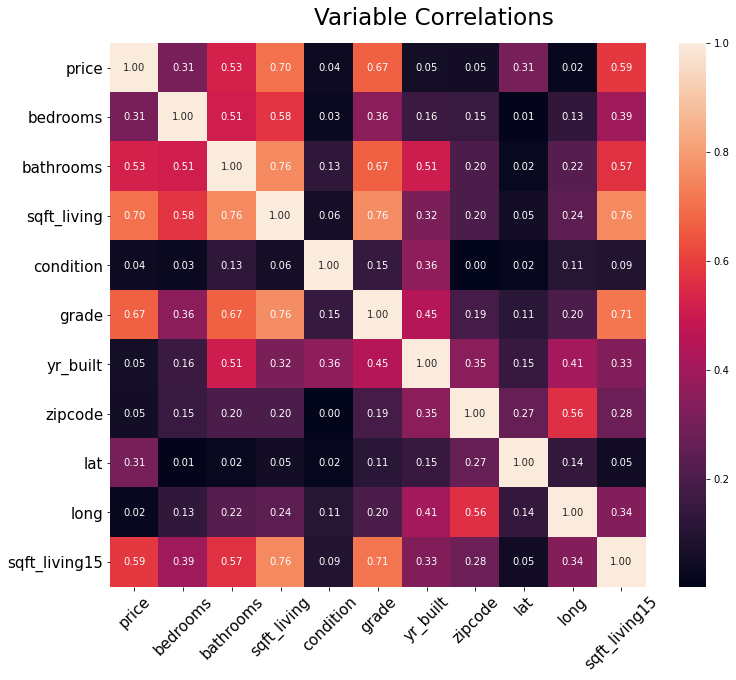

In [3]:
corr = houses_df.corr().abs()
fig, ax=plt.subplots(figsize=(12,10))
fig.suptitle('Variable Correlations', fontsize=23, y=.93)
h = sns.heatmap(corr, annot=True, fmt='.2f')
h.set_xticklabels(h.get_xmajorticklabels(), fontsize = 15, rotation=45)
h.set_yticklabels(h.get_ymajorticklabels(), fontsize = 15);

Normalizing skewed factors through log transformation: price, sqft_living

In [15]:
houses_df['log_price'] = np.log(houses_df['price'])
houses_df['log_sqft_living'] = np.log(houses_df['sqft_living'])

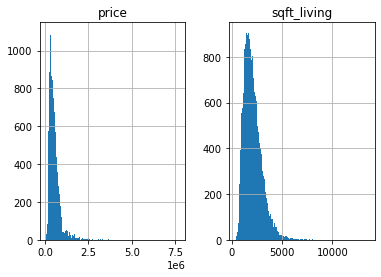

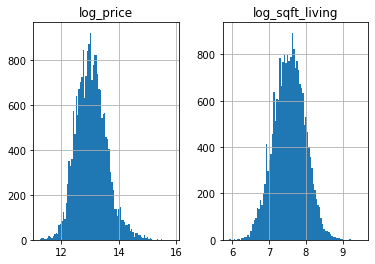

In [16]:
houses_df.hist(column=['price', 'sqft_living'], bins='auto')
houses_df.hist(column=['log_price', 'log_sqft_living'], bins='auto');

### Feature engineering

*Here's where we explain, show, and execute our creation of features such as:*
 - Distance bins!
 - ???

## Modeling

*Show our modeling process and interpret the results!*

### Baseline Model

*Explain: simplest model is 'price ~ sqft_living'*

### Model validation

*Use R^2, rmse, QQ plots, etc. to explain why our model is the bomb dot com.*

## Conclusions

Hit 'em with that knowledge, son!

**Next steps:**
 - Future 1
 - Future 2
 - Future 3